This note book train a transformer model to predict the number of sessions a student will spend in the (n+1)_th modules based on his/her performance in the previous n modules.

# Prepare Dataset

In [ ]:
!git clone https://github.com/pcarvalh/Self-regulated-spacing-online-class.git

In [ ]:
import pandas as pd
import numpy as np


In [ ]:
df = pd.read_csv('/content/Self-regulated-spacing-online-class/processed data/SummarySpacingTime.csv')  

In [ ]:
df

,ds_anon_user_id,module,meantimeToQuiz,nsessions,ndays,npages,nactivities,timeInModule,endToQuiz,meanSessionDiff,quizGrade,pretestGrade,examGrade,Nwords,Nactivities,Npages,crammers
0,Stu_00ea8f20a0942ae1385989b901bec86f,1,969.783773,4,3,27,70,7815.200000,1.833333,155008.333333,10,10.0,27,18754,79,27,Non-Crammer
1,Stu_00ea8f20a0942ae1385989b901bec86f,2,419.983333,5,2,18,69,1089.483333,60.016667,57671.333333,9,10.0,27,9546,74,25,Non-Crammer
2,Stu_00ea8f20a0942ae1385989b901bec86f,3,2429.151982,4,3,39,73,4541.850000,40.700000,44065.333333,10,10.0,27,12785,74,26,Non-Crammer
3,Stu_00ea8f20a0942ae1385989b901bec86f,4,896.453084,2,2,12,51,1499.650000,7.466667,428409.000000,9,10.0,27,9638,63,3,Non-Crammer
4,Stu_00ea8f20a0942ae1385989b901bec86f,5,1090.381925,4,3,20,29,2156.000000,18.366667,251894.200000,10,10.0,27,14163,29,18,Non-Crammer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6787,Stu_ff9a310ccbfeaadac871b45f8ded4f81,6,233.412032,2,2,19,67,1438.450000,7.283333,37608.000000,9,8.0,22,17373,80,20,Non-Crammer
6788,Stu_ff9a310ccbfeaadac871b45f8ded4f81,7,352.605721,3,2,34,74,3520.166667,8.566667,156778.666667,8,8.0,22,15293,74,10,Non-Crammer
6789,Stu_ff9a310ccbfeaadac871b45f8ded4f81,8,431.174848,4,3,20,39,2095.733333,5.000000,151080.833333,9,8.0,22,11582,39,10,Non-Crammer
6790,Stu_ff9a310ccbfeaadac871b45f8ded4f81,9,772.821111,6,3,23,36,6454.050000,6.666667,185211.750000,8,8.0,22,12430,37,14,Non-Crammer


In [ ]:
df['crammer'] = np.where(df['crammers']=='Non-Crammer', 0, 1)

In [ ]:
df = df.drop(columns=['examGrade', 'crammers'])

In [ ]:
df = df.fillna(value = {'pretestGrade':df['pretestGrade'].mean(), "meanSessionDiff":df["meanSessionDiff"].mean()})

In [ ]:
MEAN_ALL = df.mean()
STD_ALL = df.std()
for col in ['meantimeToQuiz', 'npages','nactivities','timeInModule',
            'endToQuiz','meanSessionDiff', 'pretestGrade',
            'Nwords','Nactivities','Npages','ndays','quizGrade']:
  df[col] = (df[col] - MEAN_ALL[col]).div(STD_ALL[col])

In [ ]:

df['nsessions'] = np.log1p(df['nsessions'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6792 entries, 0 to 6791
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ds_anon_user_id  6792 non-null   object 
 1   module           6792 non-null   int64  
 2   meantimeToQuiz   6792 non-null   float64
 3   nsessions        6792 non-null   float64
 4   ndays            6792 non-null   float64
 5   npages           6792 non-null   float64
 6   nactivities      6792 non-null   float64
 7   timeInModule     6792 non-null   float64
 8   endToQuiz        6792 non-null   float64
 9   meanSessionDiff  6792 non-null   float64
 10  quizGrade        6792 non-null   float64
 11  pretestGrade     6792 non-null   float64
 12  Nwords           6792 non-null   float64
 13  Nactivities      6792 non-null   float64
 14  Npages           6792 non-null   float64
 15  crammer          6792 non-null   int64  
dtypes: float64(13), int64(2), object(1)
memory usage: 849.1+ KB


In [ ]:
df.head(10)


,ds_anon_user_id,module,meantimeToQuiz,nsessions,ndays,npages,nactivities,timeInModule,endToQuiz,meanSessionDiff,quizGrade,pretestGrade,Nwords,Nactivities,Npages,crammer
0,Stu_00ea8f20a0942ae1385989b901bec86f,1,-0.333594,1.609438,0.02919,0.053546,1.037562,0.846007,-0.312039,-0.103592,0.931043,-0.265992,1.470412,0.996848,1.319891,0
1,Stu_00ea8f20a0942ae1385989b901bec86f,2,-0.398759,1.791759,-0.52153,-0.352252,1.001502,-0.647556,-0.305420,-0.484132,0.217475,-0.265992,-0.793981,0.775515,1.080312,0
2,Stu_00ea8f20a0942ae1385989b901bec86f,3,-0.160620,1.609438,0.02919,0.594611,1.145741,0.119102,-0.307617,-0.537325,0.931043,-0.265992,0.002540,0.775515,1.200101,0
3,Stu_00ea8f20a0942ae1385989b901bec86f,4,-0.342285,1.098612,-0.52153,-0.622785,0.352427,-0.556471,-0.311398,0.965271,0.217475,-0.265992,-0.771357,0.288581,-1.555061,0
4,Stu_00ea8f20a0942ae1385989b901bec86f,5,-0.319299,1.609438,0.02919,-0.262075,-0.440888,-0.410718,-0.310158,0.275184,0.931043,-0.265992,0.341412,-1.216487,0.241784,0
5,Stu_00ea8f20a0942ae1385989b901bec86f,6,-0.293376,1.386294,-0.52153,-0.307164,1.073622,-0.560050,-0.244449,-0.597795,0.217475,-0.265992,1.130802,1.041115,0.481363,0
6,Stu_00ea8f20a0942ae1385989b901bec86f,7,-0.376338,1.386294,-0.52153,0.053546,0.676964,-0.597114,-0.311106,0.847036,0.217475,-0.265992,0.619297,0.775515,-0.716533,0
7,Stu_00ea8f20a0942ae1385989b901bec86f,8,-0.308716,1.098612,-0.52153,-0.397341,-0.476948,-0.735689,-0.311836,0.165098,0.931043,-0.265992,-0.293297,-0.773820,-0.716533,0
8,Stu_00ea8f20a0942ae1385989b901bec86f,9,-0.320753,1.386294,0.02919,-0.712962,-0.260589,-0.726016,0.048682,-0.216002,0.217475,-0.265992,-0.084760,-0.862353,-0.237375,0
9,Stu_00ea8f20a0942ae1385989b901bec86f,10,-0.326665,1.386294,-0.52153,-0.667874,0.208188,-0.566720,-0.311345,0.190831,0.931043,-0.265992,0.457485,-0.021286,0.241784,0


In [ ]:
# set the n value
n = 3
DROPOUT = 0.1

# Transformer

In [ ]:
# we don't consider the users whose number of completed module in less than (n+1)
valid_user = []

for user_id in df['ds_anon_user_id'].unique():
  if len(df[df['ds_anon_user_id'] == user_id]) >= n+1:
    valid_user.append(user_id)
len(valid_user)
df = df[df.ds_anon_user_id.isin(valid_user)]

In [ ]:
# group the data by user ids
grouped_data = df[['ds_anon_user_id', 'module','quizGrade',  'nsessions','meantimeToQuiz',
                   'ndays', 'npages','nactivities','timeInModule',
                  'endToQuiz','meanSessionDiff', 'pretestGrade',
                  'Nwords','Nactivities','Npages', 
                                    ]].groupby(['ds_anon_user_id']).apply(lambda r: (
                r['module'],
                r['nsessions'],
                np.array([r['meantimeToQuiz'],r['ndays'], r['npages'], r['nactivities'],r['timeInModule'],
                  r['endToQuiz'],r['meanSessionDiff'], r['pretestGrade'], r['nsessions'],r['quizGrade'],
                  r['Nwords'],r['Nactivities'],r['Npages'] ]).transpose()
                ))
                           

In [ ]:
from torch.utils.data import Dataset, DataLoader
class SPACE_DATASET(Dataset):
    def __init__(self, data, maxlength = 12):
        super(SPACE_DATASET, self).__init__()
        self.maxlength = maxlength
        self.data = data
        self.users = list()
        for user in data.index:
            self.users.append(user)

    def __len__(self):
        return len(self.users)
    
    def __getitem__(self, ix):
        user = self.users[ix]
        user = user
        module, labels, features = self.data[user]
        #0s should be used as padding values
        module = module.values 
        labels = labels.values

        # one hot encoding for target module id
        target_module_features = [0]*11
        target_module_features[module[self.maxlength]-1] = 1
        # append the other features of target module
        target_module_features.extend(features[self.maxlength][-4:-1])

        # get module ids and user interaction informations in the previous n modules
        module = module[0:self.maxlength]
        features = features[0:self.maxlength]

        # labels is the value we want to predict: the number of session 
        # the user is going to spend on the (n+1)_th module
        labels = np.array([labels[self.maxlength]])

        # change the type of variables so that they can be served as input to encoder layers
        module = torch.from_numpy(module).long()
        labels = torch.from_numpy(labels).float()
        features = torch.from_numpy(features).float()
        target_module_features = torch.from_numpy(np.array([target_module_features])).float()
        return module, labels,features, target_module_features

In [ ]:
import torch
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(grouped_data, test_size=0.1)
train_data, val_data = train_test_split(train_data, test_size=int(len(grouped_data)*0.1))
train_data = SPACE_DATASET(train_data, n)
val_data = SPACE_DATASET(val_data, n)
test_data = SPACE_DATASET(test_data, n)
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)
item = train_data.__getitem__(0)

In [ ]:
# list of module ids
# the value we want to predict
# interaction features of the user with first n modules
# target module features
item

(tensor([1, 2, 3]),
 tensor([1.6094]),
 tensor([[-0.4409, -0.5215, -0.8933, -1.0900, -0.2048, -0.3114, -0.3849, -0.5671,
           1.0986,  0.9310,  1.4704,  0.9968,  1.3199],
         [-0.1261,  0.0292,  0.0535,  1.1818, -0.1467, -0.1551, -0.5773, -0.5671,
           1.9459,  0.9310, -0.7940,  0.7755,  1.0803],
         [-0.0168,  0.5799,  0.5495,  1.1457,  0.5668, -0.3114, -0.4225, -0.5671,
           2.0794,  0.2175,  0.0025,  0.7755,  1.2001]]),
 tensor([[ 0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000, -0.4961, -0.7714,  0.2886]]))

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = 'cpu'

In [ ]:
import torch.nn as nn
import torch.nn.functional as f
from torch.nn import Embedding, Linear, MultiheadAttention, LayerNorm, Dropout

class Encoder(nn.Module):
    
    def __init__(self, module_size=12, features_size=13,module_feature_size=14, 
                 maxlength=12, num_heads=8, embedding_size=64, dropout = DROPOUT
                ):
        
        super(Encoder, self).__init__()
        self.input_length = maxlength
        # embedding layes and line layers
        self.embedding_module = Embedding(num_embeddings = module_size, 
                                        embedding_dim = embedding_size
                                       )

        self.linear_features = Linear(features_size, embedding_size)
        self.linear_module = Linear(module_feature_size, embedding_size)
             
        
        self.embedding_pos =  Embedding(    num_embeddings = maxlength,
                                            embedding_dim = embedding_size
                                           )        

        #attention
        self.attention  = MultiheadAttention(embed_dim = embedding_size,
                                             num_heads = num_heads,
                                             dropout = dropout)
        
        self.linear1 = Linear(embedding_size, embedding_size)
        self.linear2 = Linear(embedding_size, embedding_size)
        self.norm1 = LayerNorm(embedding_size)
        self.norm2 = LayerNorm(embedding_size)
        self.dropout1 = Dropout(dropout)
        
    def __call__(self, modules, features,target_module_features,block=False):
        
        if torch.cuda.is_available():
            device = torch.device("cuda")
        else:
            device = 'cpu'

        if block:

            module_ids = self.embedding_module(modules)
            features = self.linear_features(features)
            module_features = self.linear_module(target_module_features)
            
            # summation
            x = module_ids + features + module_features
        else:
            x = modules
        pos = torch.arange(self.input_length, device=device).unsqueeze(0)
        pos = self.embedding_pos(pos)
        x = x + pos
    
        x = x.permute(1, 0, 2)
        size = x.shape[0]
        x_1 = x
        # upper triangular attention mask (np.triu)
        x, _ = self.attention(x, x, x, 
                           attn_mask = torch.from_numpy( np.triu(np.ones((size, size)), k=1).astype('bool')).to(device))
        #skip connection
        x += x_1
        x =  x.permute(1, 0, 2) 
        x =  self.dropout1(x)
        return x

In [ ]:
module_id, label,features,target_module_features = item
module_id= module_id.to(device)
features = features.to(device)
label = label.to(device)
target_module_features = target_module_features.to(device)

In [ ]:
encoder = Encoder(maxlength=n).to(device)
print(encoder(module_id, features, target_module_features,block=True).shape)

torch.Size([1, 3, 64])


In [ ]:
class SPACE(nn.Module):
    def __init__(self, num_encoders=4, embedding_size=64, maxlength=12, dropout=DROPOUT):
        super(SPACE, self).__init__()
        self.maxlength = maxlength
        self.embedding_size = embedding_size
        # stack of encoders
        self.encoders = nn.ModuleList([Encoder(embedding_size=embedding_size, maxlength=maxlength) for _ in range(num_encoders) ])
        # feed forward neural network
        self.linear1 = Linear(maxlength*embedding_size, int(maxlength*embedding_size/2))
        self.linear3 = Linear(int(maxlength*embedding_size/2), 1)
        self.dropout1 = Dropout(dropout)
        
    def __call__(self,module_id, features,target_module_features,batch=64):
        for ix, encoder in enumerate(self.encoders):
            if ix == 0:
                x = encoder(module_id, features,target_module_features, block=True)
            else:
                x = encoder(x, _, _)
        if batch>1:
            x = x.reshape(batch, self.embedding_size*self.maxlength )
            
        else:
            x = x.view(-1)
        x = self.linear1(self.dropout1(F.relu(x)))
        x =  self.linear3(x)
        return x

In [ ]:
# the model architecture
space = SPACE(maxlength=n)
space.to(device)

SPACE(
  (encoders): ModuleList(
    (0): Encoder(
      (embedding_module): Embedding(12, 64)
      (linear_features): Linear(in_features=13, out_features=64, bias=True)
      (linear_module): Linear(in_features=14, out_features=64, bias=True)
      (embedding_pos): Embedding(3, 64)
      (attention): MultiheadAttention(
        (out_proj): _LinearWithBias(in_features=64, out_features=64, bias=True)
      )
      (linear1): Linear(in_features=64, out_features=64, bias=True)
      (linear2): Linear(in_features=64, out_features=64, bias=True)
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
    )
    (1): Encoder(
      (embedding_module): Embedding(12, 64)
      (linear_features): Linear(in_features=13, out_features=64, bias=True)
      (linear_module): Linear(in_features=14, out_features=64, bias=True)
      (embedding_pos): Embedding(3, 64)
      (att

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
space = SPACE(maxlength=n, embedding_size=64)
epochs = 50
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(space.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-8)
space.to(device)
criterion.to(device)

MSELoss()

In [ ]:
from tqdm import tqdm
import torch.nn.functional as F
from sklearn.metrics import r2_score, mean_absolute_error
def train_epoch(model=space, train_iterator=train_dataloader, optim=optimizer, criterion=criterion, device=device):
    model.train()

    train_loss = []
    num_corrects = 0
    num_total = 0
    labels = []
    outs = []
    tbar = tqdm(train_iterator)
    for item in tbar:
        module_ids = item[0].to(device).long()
        label = item[1].to(device).float()
        features = item[2].to(device).float()
        target_module_features = item[3].to(device).float()

        optim.zero_grad()
        output = model(module_ids,  features,target_module_features,batch = module_ids.shape[0])
        output = torch.reshape(output, label.shape)    
        loss = criterion(output, label)
        outs.extend(output.view(-1).data.cpu().numpy())
        labels.extend(label.view(-1).data.cpu().numpy())
        loss.backward()
        optim.step()
        train_loss.append(loss.item())
        
        tbar.set_description(
            'train mse - {:.4f} train r2 - {:.4f} train mae - {:.4f}'.format(loss, 
                                                                             r2_score(label.view(-1).data.cpu().numpy(), output.view(-1).data.cpu().numpy())
                                                                             ,mean_absolute_error(label.view(-1).data.cpu().numpy(), output.view(-1).data.cpu().numpy())))
        
    loss = np.mean(train_loss)
    r2 = r2_score(labels, outs)
    mae = mean_absolute_error(labels, outs)
    return loss, r2, mae,labels, outs

In [ ]:

def val_epoch(model=space, val_iterator=val_dataloader,
              criterion=criterion, device=device):
    model.eval()

    val_loss = []
    labels = []
    outs = []
    tbar = tqdm(val_iterator)
    for item in tbar:
        module_ids = item[0].to(device).long()
        label = item[1].to(device).float()
        features = item[2].to(device).float()
        target_module_features = item[3].to(device).float()
        with torch.no_grad():
            output = model(module_ids,features,target_module_features, batch = module_ids.shape[0])
        output = torch.reshape(output, label.shape)
        loss = criterion(output, label)
        val_loss.append(loss.item())
        outs.extend(output.view(-1).data.cpu().numpy())
        labels.extend(label.view(-1).data.cpu().numpy())
        tbar.set_description('valid mse - {:.4f} r2 - {:.4f} mae - {:.4f}'.format(loss, 
                                                                      r2_score(label.view(-1).data.cpu().numpy(), output.view(-1).data.cpu().numpy())
                                                                       ,mean_absolute_error(label.view(-1).data.cpu().numpy(), output.view(-1).data.cpu().numpy())))
                             
    return np.average(val_loss), r2_score(labels, outs), mean_absolute_error(labels, outs),labels, outs

In [ ]:
for epoch in range(epochs):
    train_loss, r2 ,mae, train_labels, train_outputs = train_epoch(model = space, device=device)
    print("epoch - {} train_loss - {:.2f} r2 - {:.2f} mae - {:.2f}".format(epoch, train_loss, r2,mae))
    val_loss, r2, mae, valid_labels, val_outputs = val_epoch(model = space, device=device)
    print("epoch - {} val_loss - {:.2f} r2 - {:.2f} mae - {:.2f}".format(epoch, val_loss, r2,mae))

    # we choose the model with best validation performance
    if val_loss < bestmse:
        bestmse = val_loss
        bestmae = mae
        bestr2 = r2
        torch.save(space, 'best_model.h5')

train mse - 0.7457 train r2 - -2.3923 train mae - 0.7237: 100%|██████████| 9/9 [00:00<00:00, 51.35it/s]
valid mse - 0.1820 r2 - -1.7903 mae - 0.3660: 100%|██████████| 2/2 [00:00<00:00, 119.92it/s]
train mse - 0.3394 train r2 - -0.3020 train mae - 0.4821:  56%|█████▌    | 5/9 [00:00<00:00, 48.86it/s]

epoch - 0 train_loss - 1.12 r2 - -3.24 mae - 0.87
epoch - 0 val_loss - 0.37 r2 - -0.91 mae - 0.58


train mse - 0.2188 train r2 - 0.1543 train mae - 0.3643: 100%|██████████| 9/9 [00:00<00:00, 48.67it/s]
valid mse - 0.0887 r2 - -0.3591 mae - 0.2240: 100%|██████████| 2/2 [00:00<00:00, 99.13it/s]
train mse - 0.2037 train r2 - 0.1839 train mae - 0.3673:  67%|██████▋   | 6/9 [00:00<00:00, 53.92it/s]

epoch - 1 train_loss - 0.37 r2 - -0.41 mae - 0.50
epoch - 1 val_loss - 0.19 r2 - 0.01 mae - 0.42


train mse - 0.2112 train r2 - -0.5570 train mae - 0.3813: 100%|██████████| 9/9 [00:00<00:00, 52.32it/s]
valid mse - 0.3390 r2 - 0.2943 mae - 0.5815: 100%|██████████| 2/2 [00:00<00:00, 83.77it/s]
train mse - 0.1818 train r2 - 0.2347 train mae - 0.3490:  56%|█████▌    | 5/9 [00:00<00:00, 48.61it/s] 

epoch - 2 train_loss - 0.30 r2 - -0.13 mae - 0.44
epoch - 2 val_loss - 0.27 r2 - 0.29 mae - 0.37


train mse - 0.2594 train r2 - -0.1280 train mae - 0.4215: 100%|██████████| 9/9 [00:00<00:00, 50.19it/s]
valid mse - 0.5323 r2 - -3.4316 mae - 0.6566: 100%|██████████| 2/2 [00:00<00:00, 105.61it/s]
train mse - 0.1761 train r2 - 0.1542 train mae - 0.3420: 100%|██████████| 9/9 [00:00<00:00, 55.03it/s]
  0%|          | 0/2 [00:00<?, ?it/s]

epoch - 3 train_loss - 0.24 r2 - 0.10 mae - 0.39
epoch - 3 val_loss - 0.41 r2 - -0.04 mae - 0.44
epoch - 4 train_loss - 0.22 r2 - 0.18 mae - 0.38


valid mse - 0.1087 r2 - -7.7326 mae - 0.2884: 100%|██████████| 2/2 [00:00<00:00, 98.82it/s]
train mse - 0.2778 train r2 - -0.3371 train mae - 0.4503: 100%|██████████| 9/9 [00:00<00:00, 50.58it/s]


epoch - 4 val_loss - 0.15 r2 - 0.32 mae - 0.35
epoch - 5 train_loss - 0.23 r2 - 0.18 mae - 0.37


valid mse - 0.3716 r2 - 0.4886 mae - 0.5431: 100%|██████████| 2/2 [00:00<00:00, 104.85it/s]
train mse - 0.2440 train r2 - -0.1083 train mae - 0.3800: 100%|██████████| 9/9 [00:00<00:00, 55.42it/s]
  0%|          | 0/9 [00:00<?, ?it/s]

epoch - 5 val_loss - 0.29 r2 - 0.29 mae - 0.36
epoch - 6 train_loss - 0.20 r2 - 0.27 mae - 0.35
epoch - 6 val_loss - 0.27 r2 - 0.24 mae - 0.38


train mse - 0.1632 train r2 - 0.2804 train mae - 0.3152: 100%|██████████| 9/9 [00:00<00:00, 54.28it/s]
valid mse - 0.0371 r2 - 0.0000 mae - 0.1788: 100%|██████████| 2/2 [00:00<00:00, 101.28it/s]
train mse - 0.1896 train r2 - 0.2327 train mae - 0.3559: 100%|██████████| 9/9 [00:00<00:00, 53.24it/s]


epoch - 7 train_loss - 0.19 r2 - 0.29 mae - 0.35
epoch - 7 val_loss - 0.16 r2 - 0.06 mae - 0.42
epoch - 8 train_loss - 0.19 r2 - 0.29 mae - 0.35


valid mse - 0.4580 r2 - -6.0208 mae - 0.6693: 100%|██████████| 2/2 [00:00<00:00, 109.54it/s]
train mse - 0.3155 train r2 - 0.0038 train mae - 0.4237: 100%|██████████| 9/9 [00:00<00:00, 55.53it/s]
valid mse - 0.0624 r2 - 0.0000 mae - 0.2469: 100%|██████████| 2/2 [00:00<00:00, 99.68it/s]


epoch - 8 val_loss - 0.32 r2 - 0.35 mae - 0.35
epoch - 9 train_loss - 0.19 r2 - 0.35 mae - 0.34
epoch - 9 val_loss - 0.14 r2 - 0.30 mae - 0.36


train mse - 0.1571 train r2 - 0.4808 train mae - 0.3437: 100%|██████████| 9/9 [00:00<00:00, 48.00it/s]
valid mse - 0.2598 r2 - 0.0000 mae - 0.3724: 100%|██████████| 2/2 [00:00<00:00, 100.11it/s]
train mse - 0.2311 train r2 - 0.2471 train mae - 0.3963: 100%|██████████| 9/9 [00:00<00:00, 53.63it/s]
  0%|          | 0/2 [00:00<?, ?it/s]

epoch - 10 train_loss - 0.18 r2 - 0.34 mae - 0.34
epoch - 10 val_loss - 0.22 r2 - 0.36 mae - 0.35
epoch - 11 train_loss - 0.20 r2 - 0.25 mae - 0.36


valid mse - 0.1081 r2 - -12.0100 mae - 0.2855: 100%|██████████| 2/2 [00:00<00:00, 97.91it/s]
train mse - 0.2086 train r2 - 0.2598 train mae - 0.3635: 100%|██████████| 9/9 [00:00<00:00, 54.77it/s]
  0%|          | 0/9 [00:00<?, ?it/s]

epoch - 11 val_loss - 0.17 r2 - 0.23 mae - 0.38
epoch - 12 train_loss - 0.20 r2 - 0.28 mae - 0.36
epoch - 12 val_loss - 0.23 r2 - 0.02 mae - 0.42


train mse - 0.1947 train r2 - 0.3142 train mae - 0.3517: 100%|██████████| 9/9 [00:00<00:00, 52.33it/s]
valid mse - 0.0918 r2 - 0.2359 mae - 0.2494: 100%|██████████| 2/2 [00:00<00:00, 102.21it/s]
train mse - 0.1429 train r2 - 0.5973 train mae - 0.3243: 100%|██████████| 9/9 [00:00<00:00, 52.75it/s]


epoch - 13 train_loss - 0.18 r2 - 0.32 mae - 0.33
epoch - 13 val_loss - 0.15 r2 - 0.28 mae - 0.37


valid mse - 0.3168 r2 - -0.5094 mae - 0.5144: 100%|██████████| 2/2 [00:00<00:00, 86.58it/s]
train mse - 0.1902 train r2 - 0.3099 train mae - 0.3594:  56%|█████▌    | 5/9 [00:00<00:00, 49.59it/s]

epoch - 14 train_loss - 0.17 r2 - 0.36 mae - 0.33
epoch - 14 val_loss - 0.26 r2 - 0.30 mae - 0.36


train mse - 0.0879 train r2 - 0.5667 train mae - 0.2478: 100%|██████████| 9/9 [00:00<00:00, 50.68it/s]
valid mse - 0.0208 r2 - 0.8270 mae - 0.1261: 100%|██████████| 2/2 [00:00<00:00, 102.15it/s]
train mse - 0.1883 train r2 - 0.2527 train mae - 0.3284:  67%|██████▋   | 6/9 [00:00<00:00, 53.58it/s]

epoch - 15 train_loss - 0.16 r2 - 0.39 mae - 0.32
epoch - 15 val_loss - 0.12 r2 - 0.29 mae - 0.37


train mse - 0.1397 train r2 - 0.4001 train mae - 0.3123: 100%|██████████| 9/9 [00:00<00:00, 53.68it/s]
valid mse - 0.2111 r2 - 0.3005 mae - 0.4584: 100%|██████████| 2/2 [00:00<00:00, 102.88it/s]
train mse - 0.1422 train r2 - 0.4322 train mae - 0.3081:  56%|█████▌    | 5/9 [00:00<00:00, 47.90it/s]

epoch - 16 train_loss - 0.16 r2 - 0.42 mae - 0.32
epoch - 16 val_loss - 0.19 r2 - 0.39 mae - 0.34


train mse - 0.1995 train r2 - 0.3266 train mae - 0.3722: 100%|██████████| 9/9 [00:00<00:00, 48.93it/s]
valid mse - 0.7061 r2 - -1.6642 mae - 0.7041: 100%|██████████| 2/2 [00:00<00:00, 103.57it/s]
train mse - 0.0619 train r2 - 0.6308 train mae - 0.2062: 100%|██████████| 9/9 [00:00<00:00, 55.18it/s]
  0%|          | 0/2 [00:00<?, ?it/s]

epoch - 17 train_loss - 0.17 r2 - 0.39 mae - 0.32
epoch - 17 val_loss - 0.44 r2 - 0.34 mae - 0.35
epoch - 18 train_loss - 0.15 r2 - 0.43 mae - 0.31


valid mse - 0.2515 r2 - 0.0000 mae - 0.4420: 100%|██████████| 2/2 [00:00<00:00, 99.40it/s]
train mse - 0.1356 train r2 - 0.5052 train mae - 0.3210: 100%|██████████| 9/9 [00:00<00:00, 51.95it/s]
valid mse - 0.0950 r2 - 0.2092 mae - 0.2735: 100%|██████████| 2/2 [00:00<00:00, 109.74it/s]


epoch - 18 val_loss - 0.21 r2 - 0.38 mae - 0.34
epoch - 19 train_loss - 0.16 r2 - 0.38 mae - 0.32


train mse - 0.3759 train r2 - -0.1354 train mae - 0.5160: 100%|██████████| 9/9 [00:00<00:00, 51.33it/s]
valid mse - 0.1918 r2 - 0.3074 mae - 0.3487:   0%|          | 0/2 [00:00<?, ?it/s]

epoch - 19 val_loss - 0.13 r2 - 0.41 mae - 0.33
epoch - 20 train_loss - 0.18 r2 - 0.39 mae - 0.33


valid mse - 0.0791 r2 - 0.8912 mae - 0.2002: 100%|██████████| 2/2 [00:00<00:00, 94.99it/s]
train mse - 0.1853 train r2 - 0.4912 train mae - 0.3280: 100%|██████████| 9/9 [00:00<00:00, 52.05it/s]
valid mse - 0.3258 r2 - -2.5469 mae - 0.5613:   0%|          | 0/2 [00:00<?, ?it/s]

epoch - 20 val_loss - 0.14 r2 - 0.35 mae - 0.34
epoch - 21 train_loss - 0.17 r2 - 0.39 mae - 0.32


valid mse - 0.3258 r2 - -2.5469 mae - 0.5613: 100%|██████████| 2/2 [00:00<00:00, 96.86it/s]
train mse - 0.1376 train r2 - 0.5468 train mae - 0.2753: 100%|██████████| 9/9 [00:00<00:00, 48.48it/s]
  0%|          | 0/2 [00:00<?, ?it/s]

epoch - 21 val_loss - 0.27 r2 - 0.28 mae - 0.37
epoch - 22 train_loss - 0.15 r2 - 0.45 mae - 0.30


valid mse - 0.0287 r2 - 0.9268 mae - 0.1215: 100%|██████████| 2/2 [00:00<00:00, 84.43it/s]
train mse - 0.1981 train r2 - 0.4413 train mae - 0.3682: 100%|██████████| 9/9 [00:00<00:00, 54.75it/s]
  0%|          | 0/9 [00:00<?, ?it/s]

epoch - 22 val_loss - 0.13 r2 - 0.25 mae - 0.37
epoch - 23 train_loss - 0.17 r2 - 0.39 mae - 0.32
epoch - 23 val_loss - 0.15 r2 - 0.29 mae - 0.36


train mse - 0.2022 train r2 - 0.3303 train mae - 0.3681: 100%|██████████| 9/9 [00:00<00:00, 50.96it/s]
valid mse - 0.2187 r2 - -48.0566 mae - 0.4574: 100%|██████████| 2/2 [00:00<00:00, 112.08it/s]
train mse - 0.1623 train r2 - 0.2724 train mae - 0.3149:  56%|█████▌    | 5/9 [00:00<00:00, 47.01it/s]

epoch - 24 train_loss - 0.15 r2 - 0.44 mae - 0.31
epoch - 24 val_loss - 0.21 r2 - 0.31 mae - 0.36


train mse - 0.1616 train r2 - 0.1515 train mae - 0.3212: 100%|██████████| 9/9 [00:00<00:00, 49.40it/s]
valid mse - 0.1017 r2 - 0.7408 mae - 0.3178: 100%|██████████| 2/2 [00:00<00:00, 88.54it/s]
train mse - 0.1686 train r2 - 0.4696 train mae - 0.3044: 100%|██████████| 9/9 [00:00<00:00, 55.78it/s]
  0%|          | 0/2 [00:00<?, ?it/s]

epoch - 25 train_loss - 0.15 r2 - 0.44 mae - 0.31
epoch - 25 val_loss - 0.19 r2 - 0.08 mae - 0.42
epoch - 26 train_loss - 0.16 r2 - 0.42 mae - 0.32


valid mse - 0.3073 r2 - -1.5584 mae - 0.4240: 100%|██████████| 2/2 [00:00<00:00, 88.88it/s]
train mse - 0.2114 train r2 - 0.2242 train mae - 0.3480: 100%|██████████| 9/9 [00:00<00:00, 52.53it/s]
valid mse - 0.8878 r2 - -10.3392 mae - 0.8637: 100%|██████████| 2/2 [00:00<00:00, 104.70it/s]


epoch - 26 val_loss - 0.28 r2 - 0.13 mae - 0.41
epoch - 27 train_loss - 0.17 r2 - 0.39 mae - 0.33


train mse - 0.1017 train r2 - 0.5364 train mae - 0.2591: 100%|██████████| 9/9 [00:00<00:00, 53.73it/s]
valid mse - 0.1581 r2 - 0.3820 mae - 0.3177:   0%|          | 0/2 [00:00<?, ?it/s]

epoch - 27 val_loss - 0.53 r2 - 0.30 mae - 0.36
epoch - 28 train_loss - 0.14 r2 - 0.45 mae - 0.31


valid mse - 0.1581 r2 - 0.3820 mae - 0.3177: 100%|██████████| 2/2 [00:00<00:00, 92.82it/s]
train mse - 0.1845 train r2 - 0.0284 train mae - 0.3747: 100%|██████████| 9/9 [00:00<00:00, 54.09it/s]
valid mse - 0.1937 r2 - 0.3179 mae - 0.3544:   0%|          | 0/2 [00:00<?, ?it/s]

epoch - 28 val_loss - 0.18 r2 - 0.32 mae - 0.36
epoch - 29 train_loss - 0.15 r2 - 0.46 mae - 0.31


valid mse - 0.3280 r2 - 0.0000 mae - 0.5599: 100%|██████████| 2/2 [00:00<00:00, 82.13it/s]
train mse - 0.1437 train r2 - 0.4798 train mae - 0.3016: 100%|██████████| 9/9 [00:00<00:00, 48.77it/s]
  0%|          | 0/2 [00:00<?, ?it/s]

epoch - 29 val_loss - 0.26 r2 - 0.32 mae - 0.36
epoch - 30 train_loss - 0.15 r2 - 0.44 mae - 0.32


valid mse - 0.0866 r2 - -2.0615 mae - 0.2916: 100%|██████████| 2/2 [00:00<00:00, 81.97it/s]
train mse - 0.1563 train r2 - 0.4632 train mae - 0.3482: 100%|██████████| 9/9 [00:00<00:00, 53.59it/s]
valid mse - 0.0132 r2 - 0.6799 mae - 0.1041: 100%|██████████| 2/2 [00:00<00:00, 103.89it/s]


epoch - 30 val_loss - 0.17 r2 - 0.14 mae - 0.40
epoch - 31 train_loss - 0.16 r2 - 0.40 mae - 0.32
epoch - 31 val_loss - 0.11 r2 - 0.29 mae - 0.36


train mse - 0.2531 train r2 - 0.1808 train mae - 0.4121: 100%|██████████| 9/9 [00:00<00:00, 50.34it/s]
valid mse - 0.1746 r2 - 0.1683 mae - 0.4173: 100%|██████████| 2/2 [00:00<00:00, 84.57it/s]
train mse - 0.1568 train r2 - 0.5196 train mae - 0.3114:  67%|██████▋   | 6/9 [00:00<00:00, 51.48it/s]

epoch - 32 train_loss - 0.16 r2 - 0.45 mae - 0.30
epoch - 32 val_loss - 0.18 r2 - 0.34 mae - 0.35


train mse - 0.0946 train r2 - 0.2235 train mae - 0.2637: 100%|██████████| 9/9 [00:00<00:00, 50.70it/s]
valid mse - 0.1466 r2 - -0.2207 mae - 0.2874: 100%|██████████| 2/2 [00:00<00:00, 101.99it/s]
train mse - 0.1786 train r2 - 0.4051 train mae - 0.3447: 100%|██████████| 9/9 [00:00<00:00, 53.41it/s]
  0%|          | 0/2 [00:00<?, ?it/s]

epoch - 33 train_loss - 0.14 r2 - 0.46 mae - 0.30
epoch - 33 val_loss - 0.19 r2 - 0.22 mae - 0.38
epoch - 34 train_loss - 0.15 r2 - 0.45 mae - 0.30


valid mse - 0.0275 r2 - -0.3268 mae - 0.1655: 100%|██████████| 2/2 [00:00<00:00, 57.88it/s]
train mse - 0.1952 train r2 - 0.4466 train mae - 0.3761: 100%|██████████| 9/9 [00:00<00:00, 52.14it/s]
valid mse - 0.0561 r2 - 0.7327 mae - 0.2364: 100%|██████████| 2/2 [00:00<00:00, 104.65it/s]

epoch - 34 val_loss - 0.11 r2 - 0.33 mae - 0.35
epoch - 35 train_loss - 0.16 r2 - 0.42 mae - 0.31



train mse - 0.1189 train r2 - 0.5056 train mae - 0.2570: 100%|██████████| 9/9 [00:00<00:00, 51.96it/s]
valid mse - 0.1965 r2 - 0.3294 mae - 0.3486:   0%|          | 0/2 [00:00<?, ?it/s]

epoch - 35 val_loss - 0.12 r2 - 0.36 mae - 0.35
epoch - 36 train_loss - 0.15 r2 - 0.43 mae - 0.31


valid mse - 0.1158 r2 - 0.0360 mae - 0.3392: 100%|██████████| 2/2 [00:00<00:00, 84.32it/s]
train mse - 0.1994 train r2 - 0.1880 train mae - 0.3698: 100%|██████████| 9/9 [00:00<00:00, 49.86it/s]
  0%|          | 0/2 [00:00<?, ?it/s]

epoch - 36 val_loss - 0.16 r2 - 0.33 mae - 0.35
epoch - 37 train_loss - 0.16 r2 - 0.41 mae - 0.32


valid mse - 0.0747 r2 - -0.8176 mae - 0.2154: 100%|██████████| 2/2 [00:00<00:00, 82.67it/s]
train mse - 0.1080 train r2 - 0.5964 train mae - 0.2596: 100%|██████████| 9/9 [00:00<00:00, 51.04it/s]
valid mse - 0.2399 r2 - 0.1843 mae - 0.3835:   0%|          | 0/2 [00:00<?, ?it/s]

epoch - 37 val_loss - 0.15 r2 - 0.21 mae - 0.39
epoch - 38 train_loss - 0.14 r2 - 0.48 mae - 0.30


valid mse - 0.0940 r2 - 0.4763 mae - 0.2853: 100%|██████████| 2/2 [00:00<00:00, 90.64it/s]
train mse - 0.0921 train r2 - -0.1060 train mae - 0.2638: 100%|██████████| 9/9 [00:00<00:00, 47.54it/s]
  0%|          | 0/2 [00:00<?, ?it/s]

epoch - 38 val_loss - 0.17 r2 - 0.19 mae - 0.38
epoch - 39 train_loss - 0.14 r2 - 0.48 mae - 0.30


valid mse - 0.5180 r2 - -73.2447 mae - 0.7149: 100%|██████████| 2/2 [00:00<00:00, 91.62it/s]
train mse - 0.1418 train r2 - 0.4682 train mae - 0.3315: 100%|██████████| 9/9 [00:00<00:00, 50.90it/s]
valid mse - 0.2239 r2 - 0.2390 mae - 0.3757:   0%|          | 0/2 [00:00<?, ?it/s]

epoch - 39 val_loss - 0.37 r2 - 0.24 mae - 0.37
epoch - 40 train_loss - 0.14 r2 - 0.48 mae - 0.30


valid mse - 0.0144 r2 - 0.9197 mae - 0.1170: 100%|██████████| 2/2 [00:00<00:00, 78.56it/s]
train mse - 0.0766 train r2 - 0.6347 train mae - 0.2299: 100%|██████████| 9/9 [00:00<00:00, 50.50it/s]
valid mse - 0.2024 r2 - 0.2888 mae - 0.3576:   0%|          | 0/2 [00:00<?, ?it/s]

epoch - 40 val_loss - 0.12 r2 - 0.25 mae - 0.37
epoch - 41 train_loss - 0.13 r2 - 0.49 mae - 0.30


valid mse - 0.1060 r2 - 0.5855 mae - 0.2824: 100%|██████████| 2/2 [00:00<00:00, 85.60it/s]
train mse - 0.1255 train r2 - 0.5922 train mae - 0.2787: 100%|██████████| 9/9 [00:00<00:00, 49.74it/s]
  0%|          | 0/2 [00:00<?, ?it/s]

epoch - 41 val_loss - 0.15 r2 - 0.31 mae - 0.36
epoch - 42 train_loss - 0.14 r2 - 0.48 mae - 0.30


valid mse - 0.0777 r2 - -2.7546 mae - 0.2675: 100%|██████████| 2/2 [00:00<00:00, 89.84it/s]
train mse - 0.1658 train r2 - 0.3073 train mae - 0.3126: 100%|██████████| 9/9 [00:00<00:00, 53.75it/s]
valid mse - 0.0818 r2 - -2.9554 mae - 0.2416: 100%|██████████| 2/2 [00:00<00:00, 86.74it/s]


epoch - 42 val_loss - 0.13 r2 - 0.36 mae - 0.35
epoch - 43 train_loss - 0.14 r2 - 0.49 mae - 0.30
epoch - 43 val_loss - 0.14 r2 - 0.32 mae - 0.35


train mse - 0.0791 train r2 - 0.7853 train mae - 0.2321: 100%|██████████| 9/9 [00:00<00:00, 47.94it/s]
valid mse - 0.0397 r2 - 0.8111 mae - 0.1985: 100%|██████████| 2/2 [00:00<00:00, 83.21it/s]
train mse - 0.1254 train r2 - 0.5048 train mae - 0.2789:  67%|██████▋   | 6/9 [00:00<00:00, 54.23it/s]

epoch - 44 train_loss - 0.13 r2 - 0.49 mae - 0.30
epoch - 44 val_loss - 0.12 r2 - 0.34 mae - 0.35


train mse - 0.0651 train r2 - 0.5556 train mae - 0.2067: 100%|██████████| 9/9 [00:00<00:00, 48.45it/s]
valid mse - 0.0277 r2 - 0.0000 mae - 0.1259: 100%|██████████| 2/2 [00:00<00:00, 83.85it/s]
train mse - 0.2117 train r2 - 0.2279 train mae - 0.3761:  56%|█████▌    | 5/9 [00:00<00:00, 49.03it/s]

epoch - 45 train_loss - 0.12 r2 - 0.52 mae - 0.29
epoch - 45 val_loss - 0.12 r2 - 0.32 mae - 0.35


train mse - 0.1161 train r2 - 0.4537 train mae - 0.2708: 100%|██████████| 9/9 [00:00<00:00, 50.48it/s]
valid mse - 0.0521 r2 - 0.9283 mae - 0.2282: 100%|██████████| 2/2 [00:00<00:00, 103.16it/s]
train mse - 0.1444 train r2 - 0.4252 train mae - 0.3004:  67%|██████▋   | 6/9 [00:00<00:00, 49.70it/s]

epoch - 46 train_loss - 0.13 r2 - 0.50 mae - 0.30
epoch - 46 val_loss - 0.12 r2 - 0.36 mae - 0.34


train mse - 0.1736 train r2 - 0.3959 train mae - 0.3559: 100%|██████████| 9/9 [00:00<00:00, 49.90it/s]
valid mse - 0.2612 r2 - -5.3563 mae - 0.4682: 100%|██████████| 2/2 [00:00<00:00, 106.26it/s]
train mse - 0.1336 train r2 - 0.4307 train mae - 0.3058:  67%|██████▋   | 6/9 [00:00<00:00, 51.53it/s]

epoch - 47 train_loss - 0.14 r2 - 0.48 mae - 0.29
epoch - 47 val_loss - 0.22 r2 - 0.35 mae - 0.35


train mse - 0.1540 train r2 - 0.4778 train mae - 0.3077: 100%|██████████| 9/9 [00:00<00:00, 49.30it/s]
valid mse - 0.2027 r2 - -0.6872 mae - 0.4215: 100%|██████████| 2/2 [00:00<00:00, 98.88it/s]
train mse - 0.1094 train r2 - 0.5304 train mae - 0.2716:  56%|█████▌    | 5/9 [00:00<00:00, 43.47it/s]

epoch - 48 train_loss - 0.14 r2 - 0.47 mae - 0.30
epoch - 48 val_loss - 0.20 r2 - 0.32 mae - 0.35


train mse - 0.1075 train r2 - 0.2505 train mae - 0.2663: 100%|██████████| 9/9 [00:00<00:00, 46.38it/s]
valid mse - 0.1962 r2 - -0.6339 mae - 0.3196: 100%|██████████| 2/2 [00:00<00:00, 107.59it/s]

epoch - 49 train_loss - 0.14 r2 - 0.48 mae - 0.30
epoch - 49 val_loss - 0.20 r2 - 0.30 mae - 0.36


In [ ]:
best_model = torch.load('best_model.h5')

# Result

In [ ]:
print(df['nsessions'].std())

0.5631393221609047


In [ ]:
train_loss, r2, mae, train_labels, train_outputs = val_epoch(model = best_model, val_iterator = train_dataloader, device=device)
val_loss, r2,mae,val_labels, val_outputs = val_epoch(model = best_model, val_iterator = val_dataloader, device=device)
test_loss, r2, mae, test_labels, test_outputs = val_epoch(model = best_model, val_iterator = test_dataloader, device=device)

In [ ]:
test_exp_pred = np.expm1(test_outputs)
test_exp_label = np.expm1(test_labels)
test_rmse = np.sqrt(np.mean((test_exp_pred-test_exp_label)**2))

train_exp_pred = np.expm1(train_outputs)
train_exp_label = np.expm1(train_labels)
train_rmse = np.sqrt(np.mean((train_exp_pred-train_exp_label)**2))

val_exp_pred = np.expm1(val_outputs)
val_exp_label = np.expm1(val_labels)
val_rmse = np.sqrt(np.mean((val_exp_pred-val_exp_label)**2))
print("The metric for ", n, " are: ") 
print("TRAIN_RMSE:  %.3f\n VAL_RMSE:  %.3f\n TEST_RMSE: %.3f" % (train_rmse, val_rmse, test_rmse))

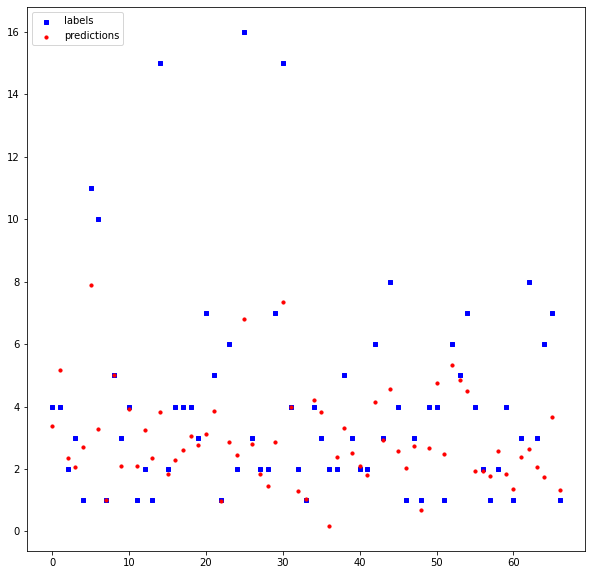

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (10, 10))
ax1 = fig.add_subplot(111)

ax1.scatter(list(range(len(test_labels))), test_exp_label, s=10, c='b', marker="s", label='labels')
ax1.scatter(list(range(len(test_outputs))),test_exp_pred, s=10, c='r', marker="o", label='predictions')
plt.legend(loc='upper left')
plt.show()